# BSPF Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

# config['path_to_data'] = data_path+"BSPF/data/ACC/"
config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['path_to_figs'] = data_path+"BSPF/figures/"

config['catalog'] = ""

config['save'] = False

config['translation_type'] = "ACC"

# config['catalog'] = "BSPF_catalog_20221001_20230930_all.pkl"
config['catalog'] = "BSPF_catalog_20221001_20231001_all.pkl"

## Load Data

In [5]:
# data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

# data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")

In [6]:
data_amax = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")

data_snr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")

data_adr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")

In [7]:
data_amax_cosum_6 = data_amax[data_amax.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]

In [8]:
## read data frame of selected triggered events
events = pd.read_pickle(config['path_to_catalogs']+config['catalog'])

events['Hdistance_km'] = np.sqrt((events.depth/1000)**2 + events.distances_km**2)

events_not_triggered = events.reset_index().rename(columns={"index":"origin"}).copy()

events_not_triggered = events_not_triggered[~events_not_triggered.origin.isin(data_amax.origin.values)]

In [9]:
events.shape, events_not_triggered.shape


((10841, 8), (10441, 9))

In [10]:
events[events.magnitude < 1.5]

,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,Hdistance_km
2023-09-30 20:56:33.150,33.021333,-116.349500,10310.0,0.90,ml,351.446138,66.100648,66.899863
2023-09-30 20:31:25.870,33.488500,-116.756333,7090.0,0.89,ml,64.052484,31.054683,31.853751
2023-09-30 12:18:42.240,33.656000,-116.715667,15470.0,0.86,ml,101.698092,24.662438,29.112828
2023-09-30 11:42:45.490,32.985167,-116.448333,12560.0,1.27,ml,359.455357,69.374592,70.502394
2023-09-30 10:20:48.980,34.012000,-116.750833,19350.0,0.76,ml,148.352820,52.248292,55.716304
...,...,...,...,...,...,...,...,...
2022-10-01 05:52:50.880,34.192500,-116.824333,6870.0,1.19,ml,152.033462,73.003543,73.326081
2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,19.684030,14.252022,16.920240
2022-10-01 04:30:50.050,34.657667,-116.335167,3860.0,1.33,ml,185.490185,116.669525,116.733361
2022-10-01 04:06:52.340,34.236000,-118.594500,2850.0,0.88,ml,108.726355,209.598906,209.618281


## Modify Data

Filter data

In [11]:
## reject nan values
print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.origin.dropna().shape[0]}")
data_amax.origin.dropna(inplace=True)

print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.origin.dropna().shape[0]}")
data_snr.origin.dropna(inplace=True)

print(f" CoSum6:  all: {data_amax_cosum_6.origin.size} no_nan: {data_amax_cosum_6.origin.dropna().shape[0]}")
data_amax_cosum_6.origin.dropna(inplace=True)

 AMAX:  all: 400 no_nan: 400
 SNR:  all: 389 no_nan: 389
 CoSum6:  all: 117 no_nan: 117


/tmp/ipykernel_173343/4006315242.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.origin.dropna(inplace=True)


In [12]:
data_amax_cosum_6.dropna(inplace=True)
data_amax_cosum_6

/tmp/ipykernel_173343/2026196946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.dropna(inplace=True)


,Torigin,Magnitude,CoincidenceSum,Mag_type,BAZ,Edistance_km,Hdistance_km,origin,BSPF__E_amax,BSPF__N_amax,...,PFO_10_Z_amax,RPFO_al_E_amax,RPFO_al_N_amax,RPFO_al_Z_amax,RPFO_in_E_amax,RPFO_in_N_amax,RPFO_in_Z_amax,RPFO_mi_E_amax,RPFO_mi_N_amax,RPFO_mi_Z_amax
0,2022-10-01 05:36:11.240,1.13,6.0,ml,199.712618,14.252022,16.920240,2022-10-01 05:36:11.240,8.901524e-08,1.557008e-07,...,0.000042,9.463886e-15,1.880708e-14,4.910344e-14,1.558853e-08,1.737238e-08,1.848088e-08,2.434853e-12,4.476550e-13,7.792405e-12
1,2022-10-01 21:26:43.530,2.08,6.0,ml,328.065144,48.053535,50.379154,2022-10-01 21:26:43.530,8.423352e-08,1.568107e-07,...,0.000055,4.599551e-14,3.488195e-14,4.714648e-14,1.548173e-08,8.633888e-09,4.182268e-08,1.069092e-11,6.032524e-12,9.452866e-12
2,2022-10-02 03:25:16.440,1.49,6.0,ml,199.394033,14.850966,16.887652,2022-10-02 03:25:16.440,1.179629e-07,1.911775e-07,...,0.000139,2.683913e-14,2.767603e-14,1.390893e-13,4.264398e-08,4.668133e-08,4.877842e-08,5.579813e-12,1.919521e-12,2.218751e-11
3,2022-10-02 15:51:37.180,1.68,6.0,ml,159.749086,15.423592,17.486703,2022-10-02 15:51:37.180,7.539872e-08,1.035255e-07,...,0.000111,1.361618e-13,1.671139e-14,5.399775e-14,3.473627e-08,3.329506e-08,1.834435e-08,1.953994e-11,1.071394e-12,1.060996e-11
4,2022-10-02 21:52:54.280,0.99,6.0,ml,199.820062,14.772415,17.645021,2022-10-02 21:52:54.280,8.117327e-08,8.394493e-08,...,0.000036,1.053575e-14,6.767836e-15,5.209282e-14,1.220552e-08,1.321738e-08,1.516258e-08,1.351239e-12,2.347985e-13,7.190973e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2023-09-11 11:15:03.740,0.84,6.0,ml,198.205436,13.948892,17.093449,2023-09-11 11:15:03.740,1.014771e-07,8.344789e-08,...,0.000023,1.238183e-14,2.256355e-14,1.077278e-14,5.909704e-10,8.247640e-09,2.452409e-09,2.624503e-12,4.222103e-12,8.298303e-13
382,2023-09-13 05:24:01.760,2.10,6.0,ml,157.541581,33.292313,36.004753,2023-09-13 05:24:01.760,1.850097e-07,2.708296e-07,...,0.000111,1.410731e-13,1.764128e-13,2.736216e-14,5.927644e-09,1.830025e-08,1.213451e-08,6.992188e-12,3.751027e-11,1.769140e-11
386,2023-09-16 12:17:55.550,1.55,6.0,ml,243.545551,31.685931,32.368045,2023-09-16 12:17:55.550,7.336958e-08,6.317327e-08,...,0.000036,6.149474e-15,3.029379e-15,6.554390e-15,7.826433e-10,2.883558e-09,5.661654e-09,2.962649e-12,4.076735e-12,1.632526e-12
391,2023-09-19 00:35:13.890,1.30,6.0,ml,182.309542,7.823210,8.781954,2023-09-19 00:35:13.890,1.194672e-07,2.311056e-07,...,0.000190,3.795958e-14,8.642307e-14,9.252733e-14,4.186328e-09,3.955772e-08,6.698767e-09,7.355095e-12,2.350866e-11,4.894288e-12


## Plots

## New fitting

In [13]:
def __ml_fit(X, a, b):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b )


def __predict_amplitude(X, a, b):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b )


def __predict_magnitude(X, a, b):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b


In [14]:
mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(data_amax.BSPF__N_amax)
amax_e = np.array(data_amax.BSPF__E_amax)
amax_z = np.array(data_amax.BSPF__Z_amax)

amax_all = np.sqrt(amax_n**2 + amax_e**2 + amax_z**2) #/2 /np.pi

## create uncertainties
data_amax['sigma'] = 1.0*np.ones(data_amax.shape[0])
data_amax['sigma'] = data_amax.sigma.where(data_amax.Magnitude > 2.5, 0.5)
sigmas = np.array(data_amax.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(data_amax.Hdistance_km)
mag_all = np.array(data_amax.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 0.1)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(1, 1.),
                               bounds=([0, 0],[5, 5]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1] = 4, 1.5



## output the new laws
print(f"\n Ml = log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1])


## ______________________________________

a_all, b_all = popt_all[0], popt_all[1]


hdist_syn = np.arange(1, 350+1, 1)
mag_syn = np.arange(-1, 6.5+0.1, 0.1)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all)


## blueSeis self-noise
limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_1hz = __predict_magnitude((limit_1hz, hdist_syn), a_all, b_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_10hz = __predict_magnitude((limit_10hz, hdist_syn), a_all, b_all)



 Ml = log10(Amax) + 3.34 log10(R) + 3.87


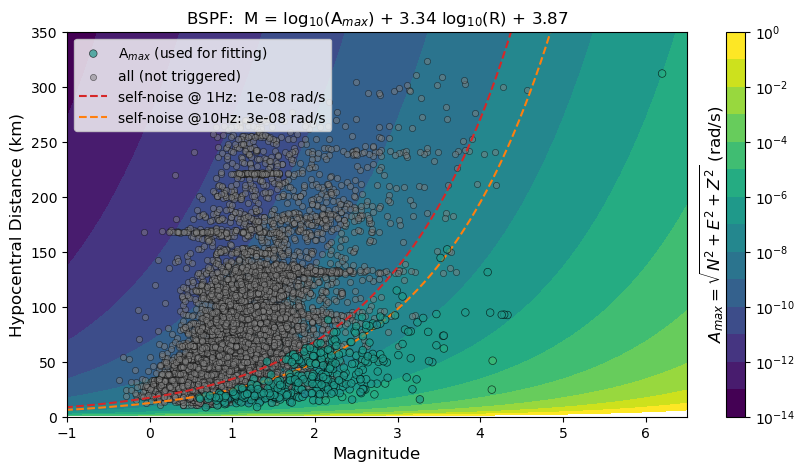

In [15]:
def __makeplot_all():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('white')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)


    ax.scatter(mag_all, hdist_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5, zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=r"A$_{max} $ (used for fitting)")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5, zorder=2, alpha=0.5, label="all (not triggered)")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(0, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2 + Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}" + " log$_{10}$" +f"(R) + {popt_all[1]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all();

fig.savefig(config['path_to_figs']+"BSPF_model1_magnitudescale_overview.png", format="png", dpi=200, bbox_inches='tight')

In [16]:
def __ml_fit(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist - c )


def __predict_amplitude(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist - c )


def __predict_magnitude(X, a, b, c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist)+ b*hdist + c


In [17]:
mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(data_amax.BSPF__N_amax)
amax_e = np.array(data_amax.BSPF__E_amax)
amax_z = np.array(data_amax.BSPF__Z_amax)

amax_all = np.sqrt(amax_n**2 + amax_e**2 + amax_z**2) #/2 /np.pi

## create uncertainties
data_amax['sigma'] = 1.0*np.ones(data_amax.shape[0])
data_amax['sigma'] = data_amax.sigma.where(data_amax.Magnitude > 2.5, 0.5)
sigmas = np.array(data_amax.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(data_amax.Hdistance_km)
mag_all = np.array(data_amax.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 0.1)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(1., -0.00001, .1),
                               bounds=([-10, -1, -10],[10, 1, 10]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1], popt_all[2] = 3.5, 0.0002, 3.0



## output the new laws
print(f"\n Ml =  log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.5f} * R + {popt_all[2]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1], popt_all[2])


## ______________________________________

a_all, b_all, c_all = popt_all[0], popt_all[1], popt_all[2]


hdist_syn = np.arange(1, 350+1, 0.5)
mag_syn = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all, c_all)


# ## blueSeis self-noise
# limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
# mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all, c_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_1hz = __predict_magnitude((limit_1hz, hdist_syn), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_10hz = __predict_magnitude((limit_10hz, hdist_syn), a_all, b_all, c_all)



 Ml =  log10(Amax) + 3.18 log10(R) + -0.00211 * R + 4.73


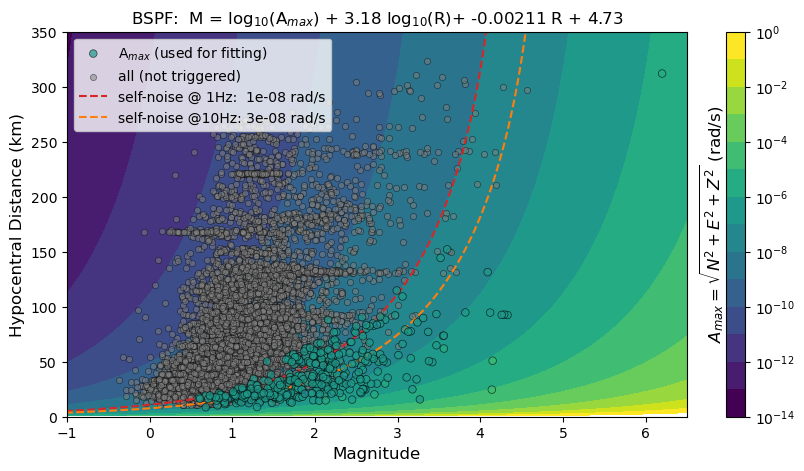

In [18]:
def __makeplot_all2():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)


    ax.scatter(mag_all, hdist_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5, zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=r"A$_{max} $ (used for fitting)")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5, zorder=2, alpha=0.5, label="all (not triggered)")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(0, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2 + Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f"+ {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all2();

fig.savefig(config['path_to_figs']+"BSPF_model2_magnitudescale_overview.png", format="png", dpi=200, bbox_inches='tight')

## Minimal Amplitude

In [19]:
def __predict_local_magnitude(X, a, b, c):
    amp, hdist = X
    return np.log10(amp) + a*np.log10(hdist) + b*hdist + c

In [20]:

a_n, b_n, c_n = popt_all[0], popt_all[1], popt_all[2]
a_e, b_e, c_e = popt_all[0], popt_all[1], popt_all[2]
a_z, b_z, c_z = popt_all[0], popt_all[1], popt_all[2]


hdist = np.arange(1, 200+1, 0.5)
mag = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_n = np.zeros((len(hdist), len(mag)))
amax_syn_e = np.zeros((len(hdist), len(mag)))
amax_syn_z = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn_n[i, j] = __predict_amplitude((m, h), a_n, b_n, c_n)
        amax_syn_e[i, j] = __predict_amplitude((m, h), a_e, b_e, c_e)
        amax_syn_z[i, j] = __predict_amplitude((m, h), a_z, b_z, c_z)


bspf_e = data_amax.BSPF__E_amax
bspf_n = data_amax.BSPF__N_amax
bspf_z = data_amax.BSPF__Z_amax

bspf_mag = data_amax.Magnitude
bspf_hdist = data_amax.Hdistance_km

## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_1hz = __predict_magnitude((limit_1hz, hdist), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_10hz = __predict_magnitude((limit_10hz, hdist), a_all, b_all, c_all)


In [21]:
def __makeplot_single():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['rainbow'].resampled(11)
    # cmap.set_under('gray')


    amin_n, amax_n = min(amax_syn_n.reshape(1, amax_syn_n.size)[0]), max(amax_syn_n.reshape(1, amax_syn_n.size)[0])
    amin_e, amax_e = min(amax_syn_e.reshape(1, amax_syn_e.size)[0]), max(amax_syn_e.reshape(1, amax_syn_e.size)[0])
    amin_z, amax_z = min(amax_syn_z.reshape(1, amax_syn_z.size)[0]), max(amax_syn_z.reshape(1, amax_syn_z.size)[0])

    amin, amax = min(amin_n, amin_e, amin_z), max(amax_n, amax_e, amax_z)

    # lev = np.logspace(round(np.log10(amin),0), round(np.log10(amax),0), 10)
    # lev = np.logspace(amin, amax, levels)
    # lev_lbl = np.linspace(amin, amax, levels).astype(int)
    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    ax[0].scatter(bspf_mag, bspf_hdist, c=bspf_n, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                  norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    cb0 = ax[0].contourf(mag, hdist, amax_syn_n, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb1 = ax[1].scatter(bspf_mag, bspf_hdist, c=bspf_e, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    ax[1].contourf(mag, hdist, amax_syn_e, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb2 = ax[2].scatter(bspf_mag, bspf_hdist, c=bspf_z, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin_z, vmax=amax_z))
    ax[2].contourf(mag, hdist, amax_syn_z, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)



    for jj in range(3):
        ax[jj].set_xlim(-1, 6.5)
        ax[jj].set_ylim(1, 200)
        ax[jj].plot(mag_limit_all_1hz, hdist, color="tab:red", ls="--")
        ax[jj].plot(mag_limit_all_10hz, hdist, color="tab:orange", ls="--")

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label("Amplitude (rad/s)", labelpad=-70, fontsize=font)

    ax[0].set_xlabel("Magnitude", fontsize=font)
    ax[0].set_ylabel("Hypocentral Distance (km)", fontsize=font)
    ax[1].set_xlabel("Magnitude", fontsize=font)
    ax[2].set_xlabel("Magnitude", fontsize=font)

    # ax[1].set_ylabel("Hypocentral Distance (km)")

    ax[0].set_title("BSPF-N")
    ax[0].set_title("BSPF-N")
    ax[1].set_title("BSPF-E")
    ax[2].set_title("BSPF-Z")

    plt.show();
    return fig

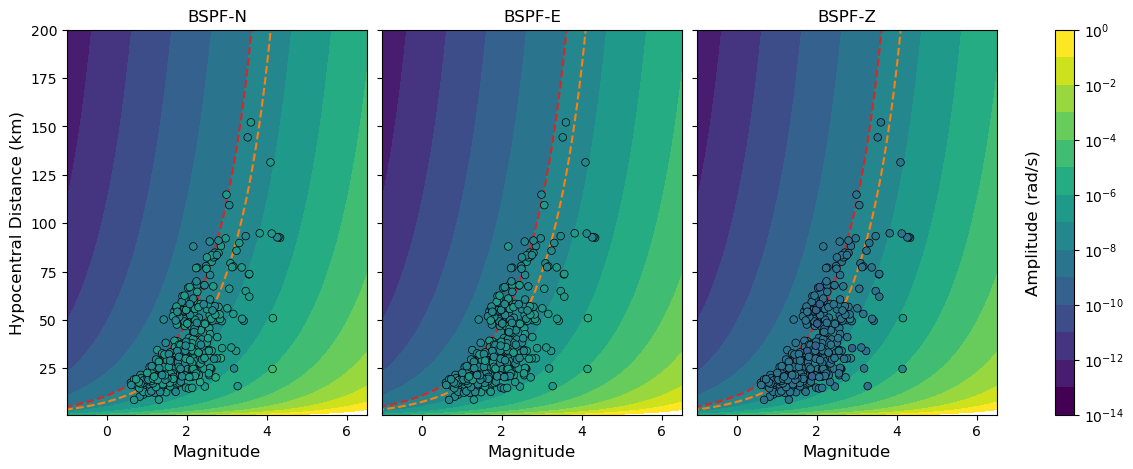

In [22]:
fig = __makeplot_single();

fig.savefig(config['path_to_figs']+"BSPF_model_magnitudescale_components.png", format="png", dpi=200, bbox_inches='tight')